In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv(r'../03-classification/data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### 4.2 Accuracy and dummy model

In [8]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.607
0.15 0.663
0.20 0.705
0.25 0.735
0.30 0.759
0.35 0.768
0.40 0.781
0.45 0.791
0.50 0.806
0.55 0.801
0.60 0.798
0.65 0.785
0.70 0.767
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


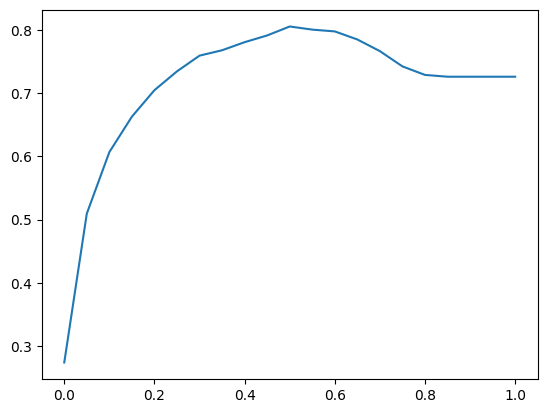

In [9]:
plt.plot(thresholds, scores)

Linear regression works in such a way that 0.5 is the best threshold.

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [12]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.607
0.15 0.663
0.20 0.705
0.25 0.735
0.30 0.759
0.35 0.768
0.40 0.781
0.45 0.791
0.50 0.806
0.55 0.801
0.60 0.798
0.65 0.785
0.70 0.767
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [13]:
from collections import Counter

In [14]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Because we are in a situation of class imbalance (a lot more customers are not churning), the accuracy score is not a helpful metric for assessing the model. If the model assumes that no customer is churning, then the accuracy would be 73%, which is not far from the 81% that the model achieved.

### 4.3 Confusion Table

| Prediction | Outcome | Prediction assessment |
| --- | --- | --- |
| Churn (positive) | Customer churned | True positive |
| Churn (positive) | Customer didn't churn | False positive |
| No churn (negative) | Customer churned | False negative |
| No churn (negative) | Customer didn't churn | True negative |

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [18]:
tp, tn, fp, fn

(np.int64(214), np.int64(921), np.int64(102), np.int64(172))

In [19]:
sum((tp, tn, fp, fn))

np.int64(1409)

In [20]:
len(y_val)

1409

In [21]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[921, 102],
       [172, 214]])

### 4.4 Precision and Recall

Precision: fraction of **positive** predictions that are correct.

In [22]:
precision = tp / (tp + fp)
precision

np.float64(0.6772151898734177)

Recall: fraction of correctly identified positive examples

In [23]:
recall = tp / (tp + fn)
recall

np.float64(0.5544041450777202)

| | $g(x_i) < t$ | $g(x_i) \ge t$ | |
| :---: | :---: | :---: | :---: |
| **$y=0$** | **TN** | **FP** | |
| **$y=1$** | **FN** | **TP** | $\rightarrow$ **Recall** |
| | | $\downarrow$ | |
| | | **Precision** | |

### 4.5 ROC Curves

In [24]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5544041450777202)

In [25]:
fpr = fp / (tn + fp)
fpr

np.float64(0.09970674486803519)

We want to minimize fpr and maximize tpr.

The ROC (receiver operating characteristics) evaluates these two values for all threshold values.

In [26]:
scores = []

thresholds = np.linspace(0, 1, 101)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, tn, fp, fn))

In [27]:
columns = ["threshold", "tp", "tn", "fp", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)

In [28]:
df_scores.head()

,threshold,tp,tn,fp,fn
0,0.00,386,0,1023,0
1,0.01,385,124,899,1
2,0.02,383,217,806,3
3,0.03,382,272,751,4
4,0.04,382,312,711,4


In [29]:
df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
df_scores["fpr"] = df_scores["fp"] / (df_scores["tn"] + df_scores["fp"])

In [30]:
df_scores.head()

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.00,386,0,1023,0,1.000000,1.000000
1,0.01,385,124,899,1,0.997409,0.878788
2,0.02,383,217,806,3,0.992228,0.787879
3,0.03,382,272,751,4,0.989637,0.734115
4,0.04,382,312,711,4,0.989637,0.695015


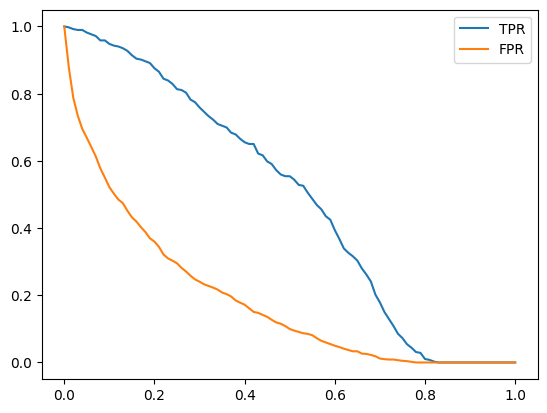

In [31]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")
plt.legend()

**Random model**

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [33]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [34]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    
    thresholds = np.linspace(0, 1, 101)
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        scores.append((t, tp, tn, fp, fn))

    columns = ["threshold", "tp", "tn", "fp", "fn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
    df_scores["fpr"] = df_scores["fp"] / (df_scores["tn"] + df_scores["fp"])

    return df_scores

In [35]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [36]:
df_rand[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,347,100,923,39,0.898964,0.902248
20,0.2,307,201,822,79,0.795337,0.803519
30,0.3,276,299,724,110,0.715026,0.707722
40,0.4,237,399,624,149,0.613990,0.609971
50,0.5,202,505,518,184,0.523316,0.506354
60,0.6,161,614,409,225,0.417098,0.399804
70,0.7,121,721,302,265,0.313472,0.295210
80,0.8,78,817,206,308,0.202073,0.201369
90,0.9,40,922,101,346,0.103627,0.098729


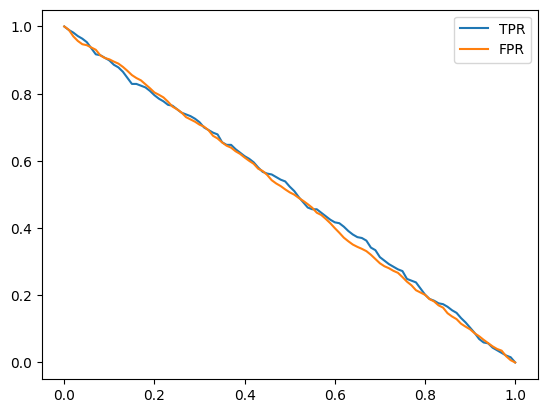

In [37]:
plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")
plt.legend()

**Ideal model**

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [39]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [40]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [41]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [42]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [43]:
df_ideal[::10]

,threshold,tp,tn,fp,fn,tpr,fpr
0,0.0,386,0,1023,0,1.000000,1.000000
10,0.1,386,141,882,0,1.000000,0.862170
20,0.2,386,282,741,0,1.000000,0.724340
30,0.3,386,423,600,0,1.000000,0.586510
40,0.4,386,564,459,0,1.000000,0.448680
50,0.5,386,704,319,0,1.000000,0.311828
60,0.6,386,845,178,0,1.000000,0.173998
70,0.7,386,986,37,0,1.000000,0.036168
80,0.8,282,1023,0,104,0.730570,0.000000
90,0.9,141,1023,0,245,0.365285,0.000000


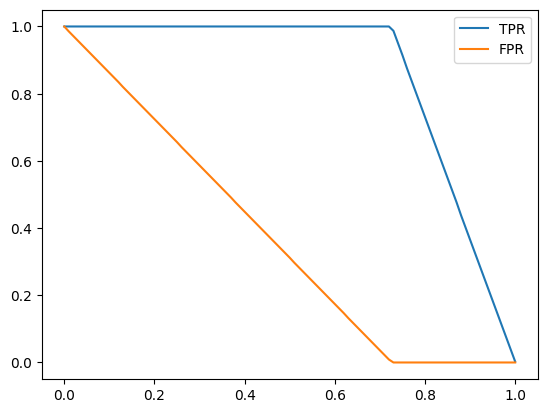

In [44]:
plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR")
plt.legend()

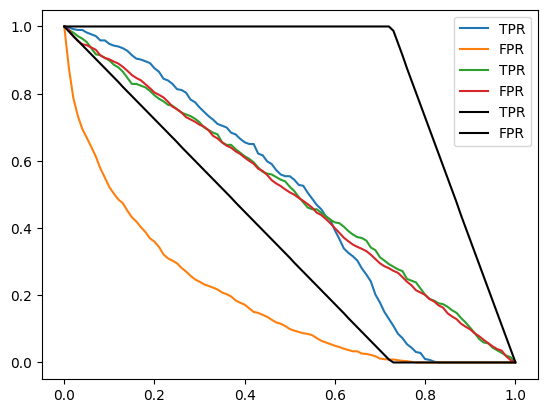

In [47]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")
plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")
plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR", color="black")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR", color="black")
plt.legend()

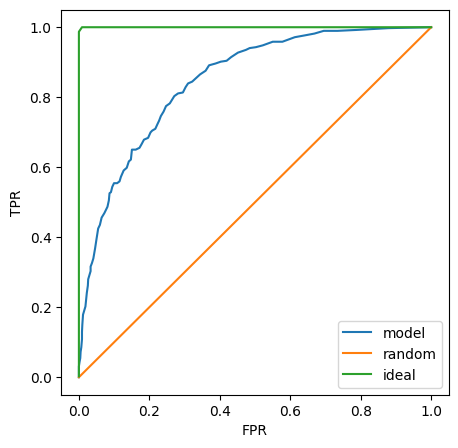

In [52]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores["fpr"], df_scores["tpr"], label="model")
plt.plot([0, 1], [0, 1], label= "random")
# plt.plot(df_rand["fpr"], df_rand["tpr"], label= "random")
plt.plot(df_ideal["fpr"], df_ideal["tpr"], label= "ideal")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

In [49]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

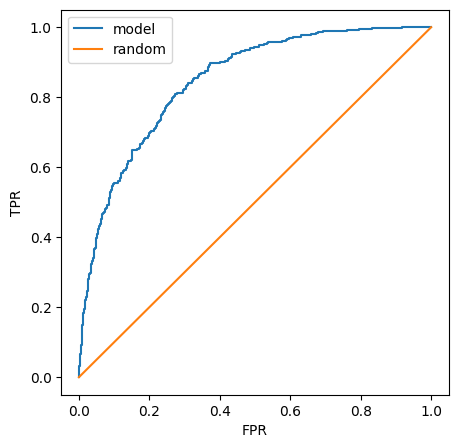

In [51]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label="model")
plt.plot([0, 1], [0, 1], label= "random")

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

### 4.6 ROC AUC

Measuring the area under the curve (AUC) of the model is one way of measuring how close we are to the ideal curve.
Our model should have an AOC somewhere between 0.5 and 1.0.

In [53]:
from sklearn.metrics import auc

In [56]:
auc(fpr, tpr)  # Values calculated with sklearn

0.8464234523067885

In [57]:
auc(df_scores["fpr"], df_scores["tpr"])  # Values calculated manually

0.8462411175097118

In [58]:
auc(df_ideal["fpr"], df_ideal["tpr"])

0.9999430203759136

In [59]:
from sklearn.metrics import roc_auc_score

In [60]:
roc_auc_score(y_val, y_pred)

0.8464234523067885

The AUC is a measure of the probability that a randomly selected positive example has a higher score than a randomly selected negative example

In [61]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [63]:
import random

In [67]:
n = 10000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.8452

In [69]:
n = 10000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [70]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8454)